I'd like to demonstrate deriving and running a tobit style regression in Stan.

This note is part of a series of "solving problems with Stan" that I am working on. The series currently includes:

  * [Dealing with range censored data, or tobit style regression](https://github.com/WinVector/Examples/blob/main/linear_regression_w_zeros/tobit.ipynb) (this note).
  * [Learning rank preferences from actions](https://github.com/WinVector/Examples/blob/main/rank/LearningToRank.pdf).
  * [Time series with external explanatory variables](https://github.com/WinVector/Examples/blob/main/TimeSeries/nested_model_example.ipynb).


To start, let's set up a censored data problem such as in [Post-hoc Adjustment for Zero-Thresholded Linear Models](https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/). That is: a regression style problem (predicting a numeric dependent outcome) where for negative outcomes we are only told "0" (and not the actual value).

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

Our data looks like the following.

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def true_process(mu: float = 0.0, N: int = 500):
  x = 3 * rng.normal(size=N, loc=mu)
  f_x = x / np.e - 1
  y = np.maximum(0.0, f_x + 0.5 * rng.normal(size=N))
  y_ideal = np.maximum(0.0, f_x)
  df = pd.DataFrame({
    'x': x, 
    'y': y, 
    'y_ideal': y_ideal,
    })
  return df

d_train = true_process()
d_test = true_process()


d_train

,x,y,y_ideal
0,3.086571,0.000000,0.135486
1,4.925760,0.901341,0.812086
2,3.440159,0.507536,0.265564
3,-2.919539,0.000000,0.000000
4,-4.178400,0.000000,0.000000
...,...,...,...
495,-0.125290,0.000000,0.000000
496,3.975848,0.208396,0.462633
497,-3.384108,0.000000,0.000000
498,2.888455,0.000000,0.062603


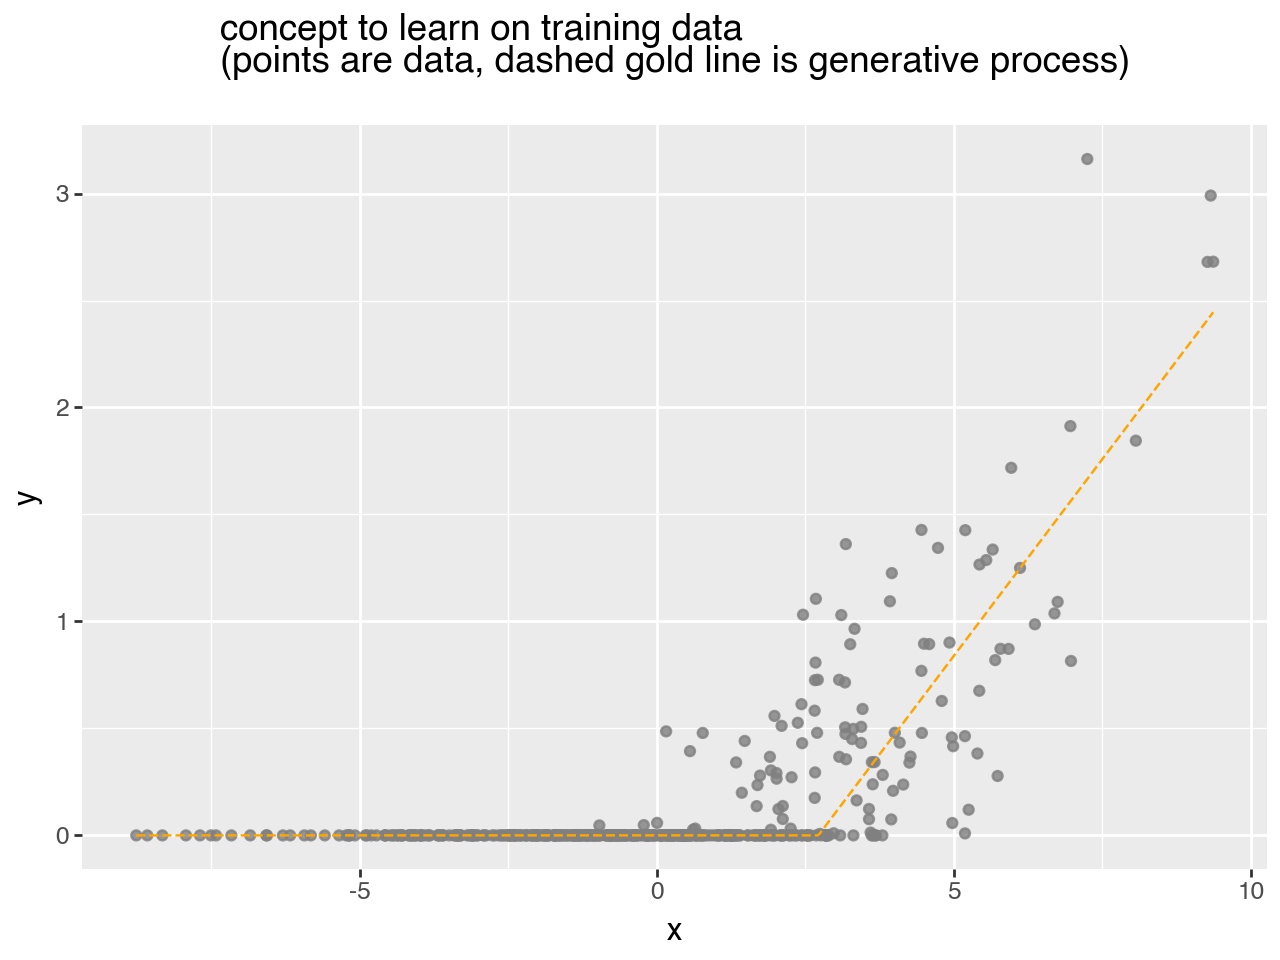

In [4]:
(
    ggplot(
        data=d_train, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("""concept to learn on training data
(points are data, dashed gold line is generative process)
""")
)

If we just try a linear regression on all the data we get the following.

In [5]:

lm0 = LinearRegression()
lm0.fit(
    d_train.loc[:, ['x']],
    d_train.loc[:, 'y'],
)

d_test['ypred0'] = np.maximum(
    0, 
    lm0.predict(d_test.loc[:, ['x']]))

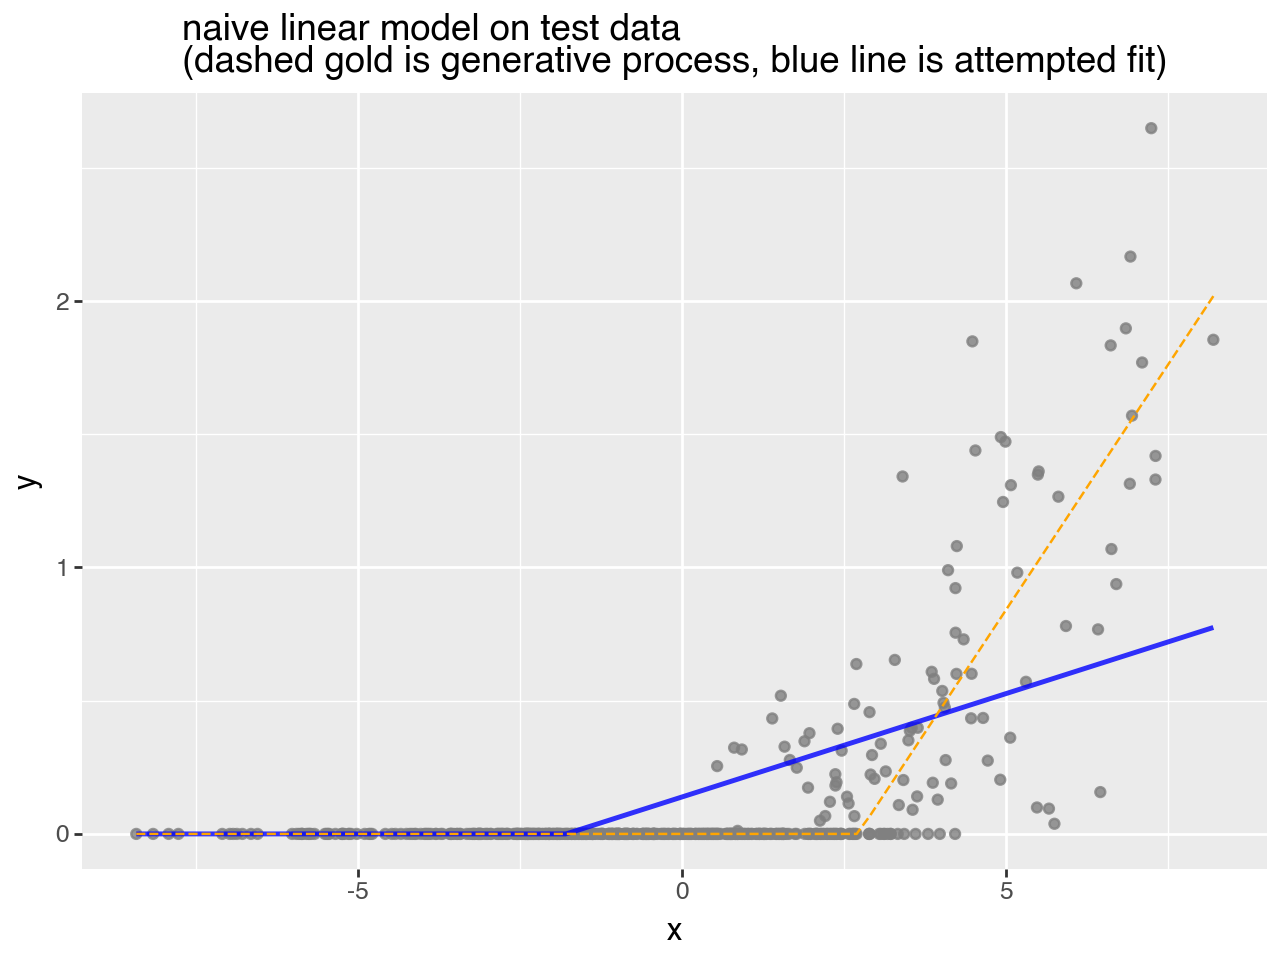

In [6]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue",
        alpha=0.8,
        size=1) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("""naive linear model on test data
(dashed gold is generative process, blue line is attempted fit)""")
)

If we try a linear regression on only the data with positive outcomes we get the following.

In [7]:

lmp = LinearRegression()
lmp.fit(
    d_train.loc[d_train['y'] > 0, ['x']],
    d_train.loc[d_train['y'] > 0, 'y'],
)

d_test['ypred_pos'] = np.maximum(
    0, 
    lmp.predict(d_test.loc[:, ['x']]))

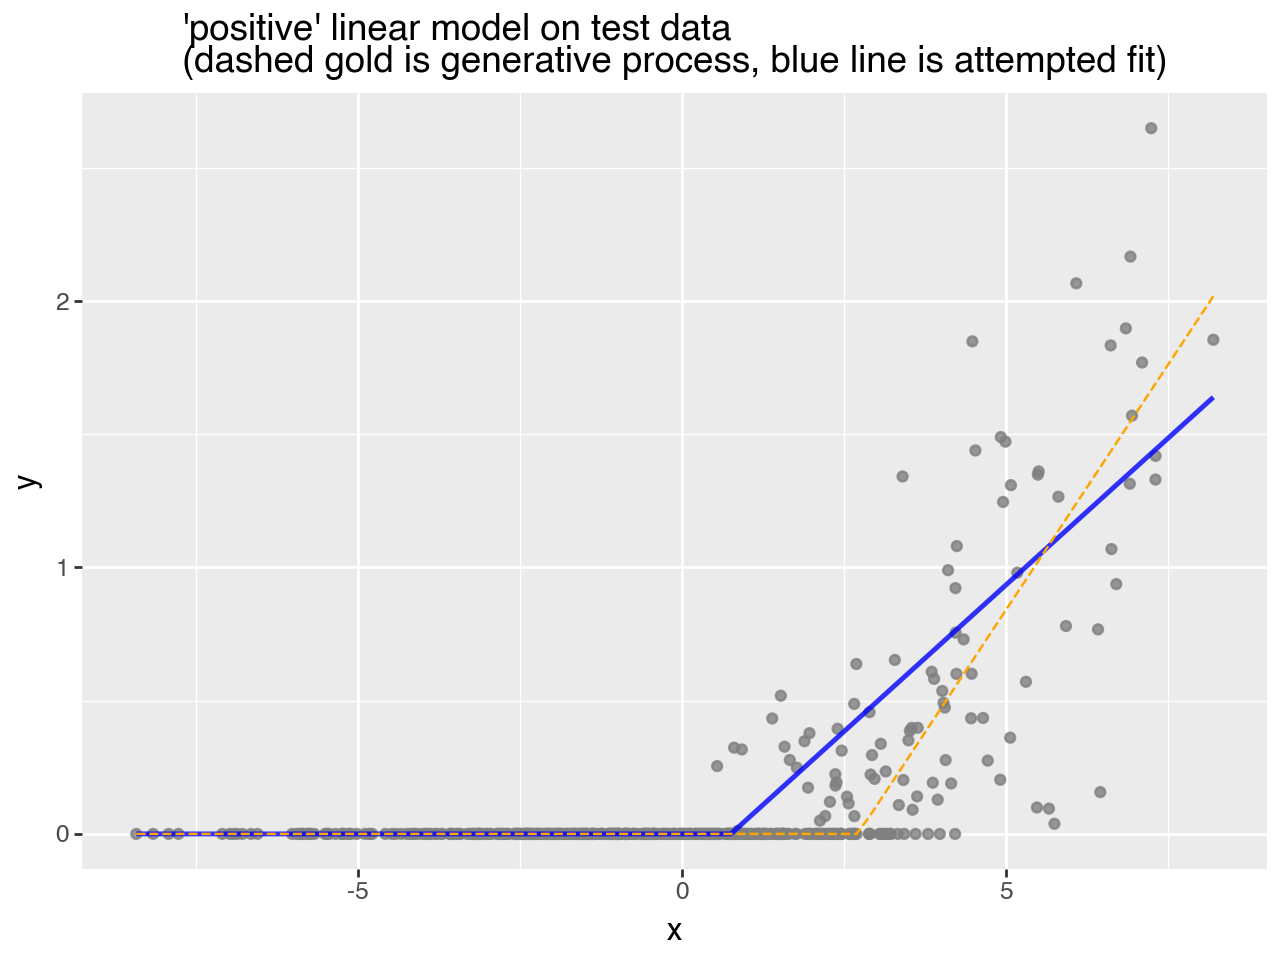

In [8]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred_pos'),
        color="blue",
        alpha=0.8,
        size=1) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("""'positive' linear model on test data
(dashed gold is generative process, blue line is attempted fit)""")
)

Notice in both cases: we fail to fit the actual underlying relation.

Now let's try Stan. The idea for the Stan model is very close to [James Tobin,"Estimation of Relationships for Limited Dependent Variables", Econometrica, Jan., 1958, Vol. 26, No. 1 (Jan., 1958), pp. 24-36](https://www.jstor.org/stable/1907382). Or "tobit" regression.

The idea is: what criticism can we derive for each training point? Let's assume a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) on observations given mean and variance (i.e. normally distributed residuals or noise). Then there are two cases:

  * `y > 0`. This is the classic linear regression case. We can assume the log-penalty for such an observation is `log(P[data | parameters]) = log(f(y, | predicted mean, sigma))` where `f()` is the PDF of the normal distribution. This gives us the usual least-squares loss function. Note this is strictly a density, not a usual probability (though we will treat it as such). In Stan the logarithm of this value is written as `normal_lpdf(y_pos | x_pos * a + b, sigma)`.
  * `y = 0`. This case is the clever idea. When we see `y = 0` we know there was an unobserved value `t <= 0`. The probability of seeing `t <= 0 | predicted mean, sigma` is (again under a normality assumption). This is written as: <code>&Phi;(0 | predicted mean, sigma)</code>, where <code>&Phi;()</code> is the CDF of the normal distribution. In Stan the logarithm of this value is written as `normal_lcdf(0 | x_zero * a + b, sigma)`.

In Stan we can collect the sum of all of our logarithmic criticisms using a special `target +=` notation. The Stan sampler then tries to find parameters such that the target value is large (or our criticisms are not pulling too far down).

The full Stan program looks like the following.

In [9]:
# specify our Stan model, as a pure criticism of proposed solutions
stan_model_criticism_src = """
data {
  int<lower=1> n_vars;               // number of explanatory variables
  int<lower=0> m_positive;           // number of positive observations
  int<lower=0> m_zero;               // number of zero observations
  matrix[m_positive, n_vars] x_pos;  // explanatory variable for positive outcomes
  vector[m_positive] y_pos;          // observed positive outcomes
  matrix[m_zero, n_vars] x_zero;     // explanatory variable for non-positive outcomes
}
parameters {
  vector[n_vars] a;                  // regression slope(s)
  real b;                            // regression intercept
  real<lower=0> sigma;               // variance / noise level
}
model {
  target += normal_lpdf(y_pos | x_pos * a + b, sigma);
  target += normal_lcdf(0 | x_zero * a + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

Let's copy our data over to Stan and run the Stan sampler.

In [10]:
# organize training data for export
pos_positions = d_train['y'] > 0
x_pos = [[x] for x in d_train['x'][pos_positions]]
y_pos = list(d_train['y'][pos_positions])
x_zero = [[x] for x in d_train['x'][pos_positions == False]]

data_str = f"""
{{
    "n_vars" : 1,
    "m_positive" : {len(x_pos)},
    "m_zero" : {len(x_zero)},
    "x_pos" : {x_pos},
    "y_pos" : {y_pos},
    "x_zero" : {x_zero}
}}
"""

# export data
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

print(data_str)


{
    "n_vars" : 1,
    "m_positive" : 109,
    "m_zero" : 391,
    "x_pos" : [[4.92576012201345], [3.440158588789841], [5.430856722885849], [2.252530419461755], [1.9192786617943873], [4.453216757051106], [2.4345603509446727], [2.709189233230887], [4.973052165593791], [3.597561496848706], [3.6335834081054097], [1.9029028243320547], [5.5445018859632], [4.005812186246286], [3.4370317016746985], [2.660706213350811], [5.920666020987925], [3.166924631431211], [2.372030148446804], [2.6553923886981328], [6.746424225317705], [6.961060142298645], [0.5578287926290123], [1.2152051516700768], [3.104850451055723], [5.652779100275561], [4.583876345220418], [3.1688990281091662], [1.6939591301816832], [5.965120191296535], [2.670589396708531], [7.245402443506883], [4.251428394394446], [0.6456580862219304], [2.6570134604429745], [5.186585696874835], [5.7842603865958635], [3.570509750396085], [2.676754181552428], [3.3276281449657654], [6.692642203185458], [3.6189871920428356], [3.5707636410773644], [4.0

In [11]:
def run_stan_model(
        stan_model_src: str,
        *,
        stan_file_name: str = 'tmp.stan'): 
    # build model
    with open(stan_file_name, 'w', encoding='utf8') as file:
        file.write(stan_model_src)
    # instantiate the model object
    model = CmdStanModel(stan_file=stan_file_name)

    # perform sampling
    fit = model.sample(
        data=data_file,
        show_progress=False,
        show_console=False,
        )

    # retrieve results
    return fit.draws_pd()

In [12]:
res = run_stan_model(
    stan_model_criticism_src, 
    stan_file_name='criticism_model.stan')

What we get back from Stan is the following data frame. One row for each Stan sample replication, and one column for each estimated parameter.

In [13]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a[1],b,sigma
0,-141.992,0.996705,0.308761,3.0,7.0,0.0,143.399,0.342499,-0.951675,0.544928
1,-143.218,0.984219,0.308761,2.0,3.0,0.0,143.582,0.339458,-0.920827,0.575324
2,-141.435,0.983641,0.308761,2.0,5.0,0.0,144.415,0.359283,-0.940215,0.497049
3,-142.394,0.843940,0.308761,2.0,7.0,0.0,143.188,0.365274,-0.913141,0.522949
4,-144.069,0.897763,0.308761,3.0,7.0,0.0,145.774,0.330861,-0.846652,0.563986
...,...,...,...,...,...,...,...,...,...,...
3995,-142.034,0.959063,0.337920,3.0,11.0,0.0,142.332,0.338747,-0.827826,0.480096
3996,-141.605,0.999336,0.337920,3.0,15.0,0.0,142.494,0.336320,-0.914140,0.507757
3997,-141.442,0.893003,0.337920,2.0,3.0,0.0,142.956,0.342012,-0.863161,0.510514
3998,-141.744,0.997439,0.337920,3.0,7.0,0.0,142.218,0.366765,-0.946924,0.503583


We want the `lp__` to be large, uni-modal, and low standard deviation. Each of these is evidence of a good sampling outcome.

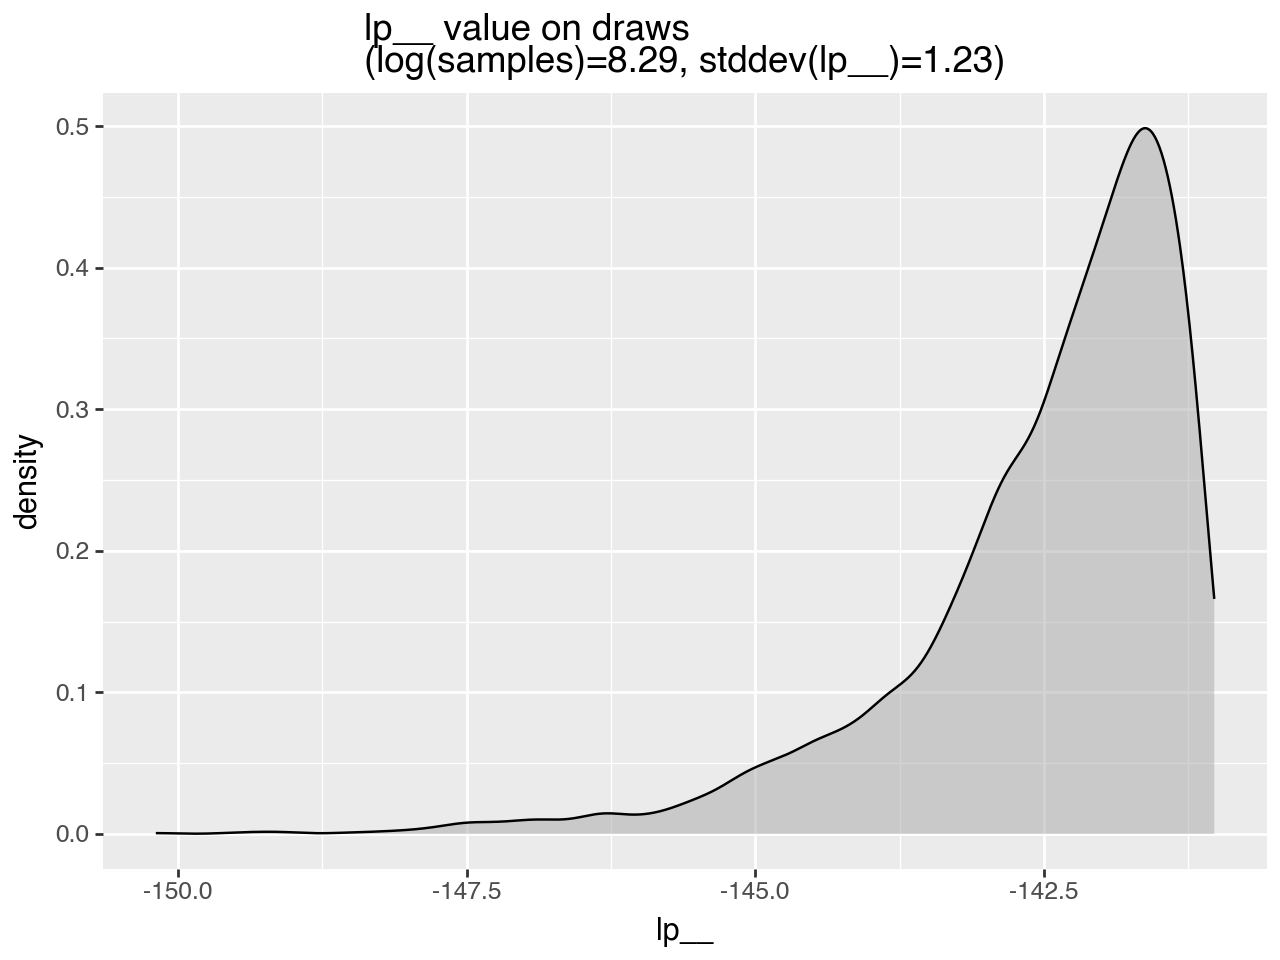

In [14]:
# show distribution of log model criticism
log_n_res = np.log(res.shape[0])
std_lp = np.std(res['lp__'])
(
    ggplot(
        data=res,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"""lp__ value on draws
(log(samples)={log_n_res:.2f}, stddev(lp__)={std_lp:.2f})""")
)

Our model parameter estimates can be gotten by aggregating the samples.

In [15]:
(res['a[1]'].mean(), res['b'].mean())

(0.35094137175, -0.9285877290000001)

We can also play some tricks, such as taking only estimates with large `lp__`.

In [16]:
# sample down to more likely returns (not strictly necessary)
res_picked = res.loc[
    res['lp__'] >= np.quantile(res['lp__'], q=0.9), 
    :].reset_index(drop=True, inplace=False)




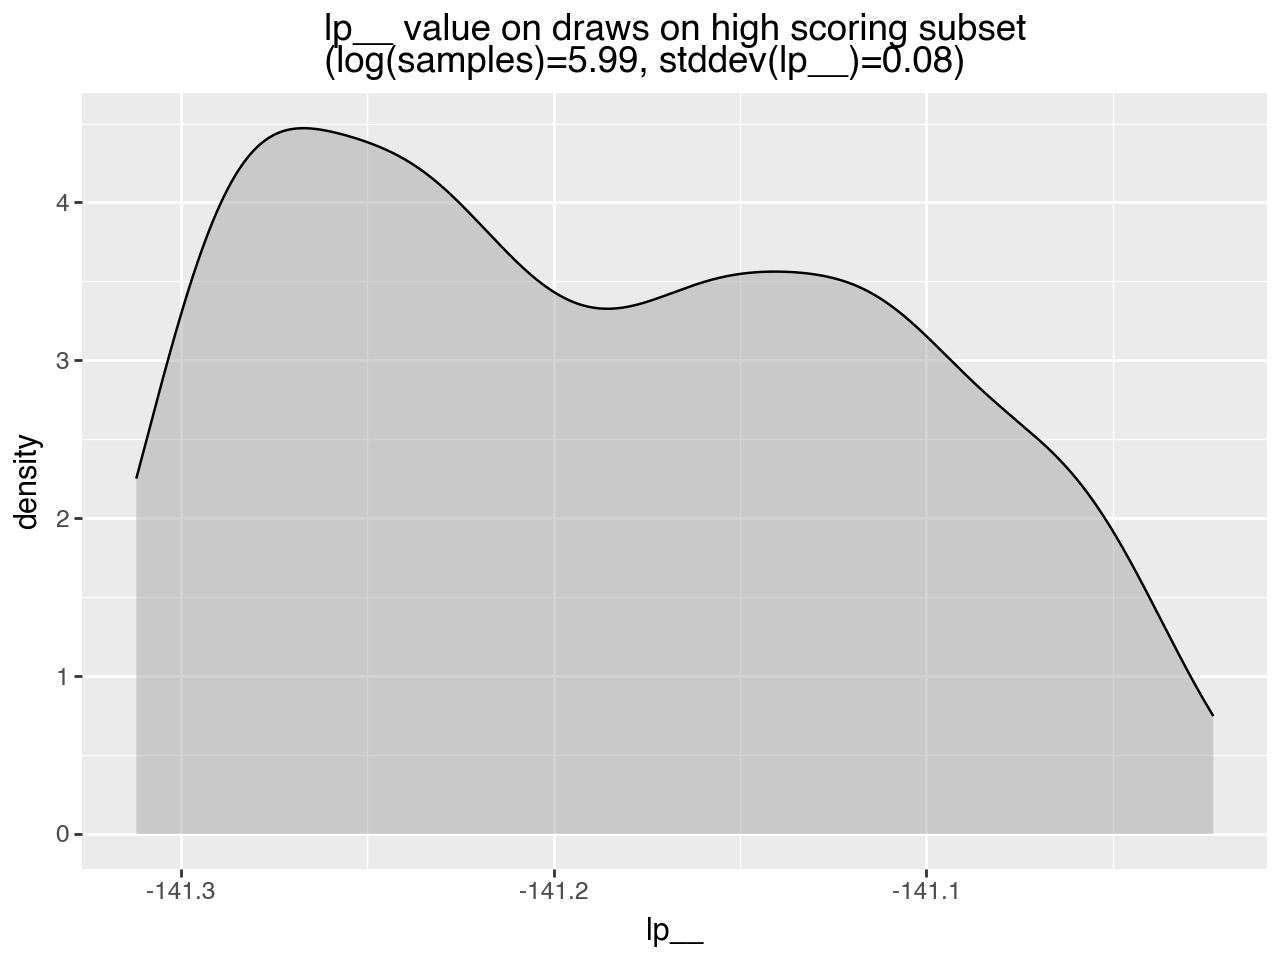

In [17]:
# show distribution of restricted model criticisms
log_n_res_picked = np.log(res_picked.shape[0])
std_lp_picked = np.std(res_picked['lp__'])
(
    ggplot(
        data=res_picked,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"""lp__ value on draws on high scoring subset
(log(samples)={log_n_res_picked:.2f}, stddev(lp__)={std_lp_picked:.2f})""")
)

Once we have our model parameter estimates we can plot the quality of the fit on held-out or test data. Notice once we have the parameters, we don't need to call Stan again.

In [18]:
def add_in_predictions_and_plot(res_picked: pd.DataFrame, *, model_name: str):
    # land predictions
    a = res_picked['a[1]'].mean()
    b = res_picked['b'].mean()
    d_test[model_name] = np.maximum(
        0, 
        a * d_test['x'] + b)
    # get upper/lower 1-sd band for predictions (at a 90% quantile of samples)
    evals = np.array([
        np.maximum(
            0, 
            res_picked.loc[i, 'a[1]'] * d_test['x'] + res_picked.loc[i, 'b'] - res_picked.loc[i, 'sigma']) 
            for i in range(res_picked.shape[0])
        ])
    d_test[f'{model_name} q0.1'] = np.quantile(evals, q=0.1, axis=0)
    evals = np.array([
        np.maximum(
            0, 
            res_picked.loc[i, 'a[1]'] * d_test['x'] + res_picked.loc[i, 'b'] + res_picked.loc[i, 'sigma']) 
            for i in range(res_picked.shape[0])
        ])
    d_test[f'{model_name} q0.9'] = np.quantile(evals, q=0.9, axis=0)
    return (
        ggplot(
            data=d_test, 
            mapping=aes(x='x', y='y')) + 
        geom_point(
            mapping=aes(y='y'),
            color="gray", alpha=0.8) +
        geom_line(
            mapping=aes(y=model_name),
            color="blue",
            alpha=0.8,
            size=1) +
        geom_line(
            mapping=aes(y='y_ideal'),
            color="orange", linetype='--') + 
        geom_ribbon(mapping=aes(
            ymin=f'{model_name} q0.1', 
            ymax=f'{model_name} q0.9'), 
            alpha=0.3, fill='blue') +
        ggtitle(f"""{model_name} on test data
(band is 1-sigma modeled distribution of data)""")
    )

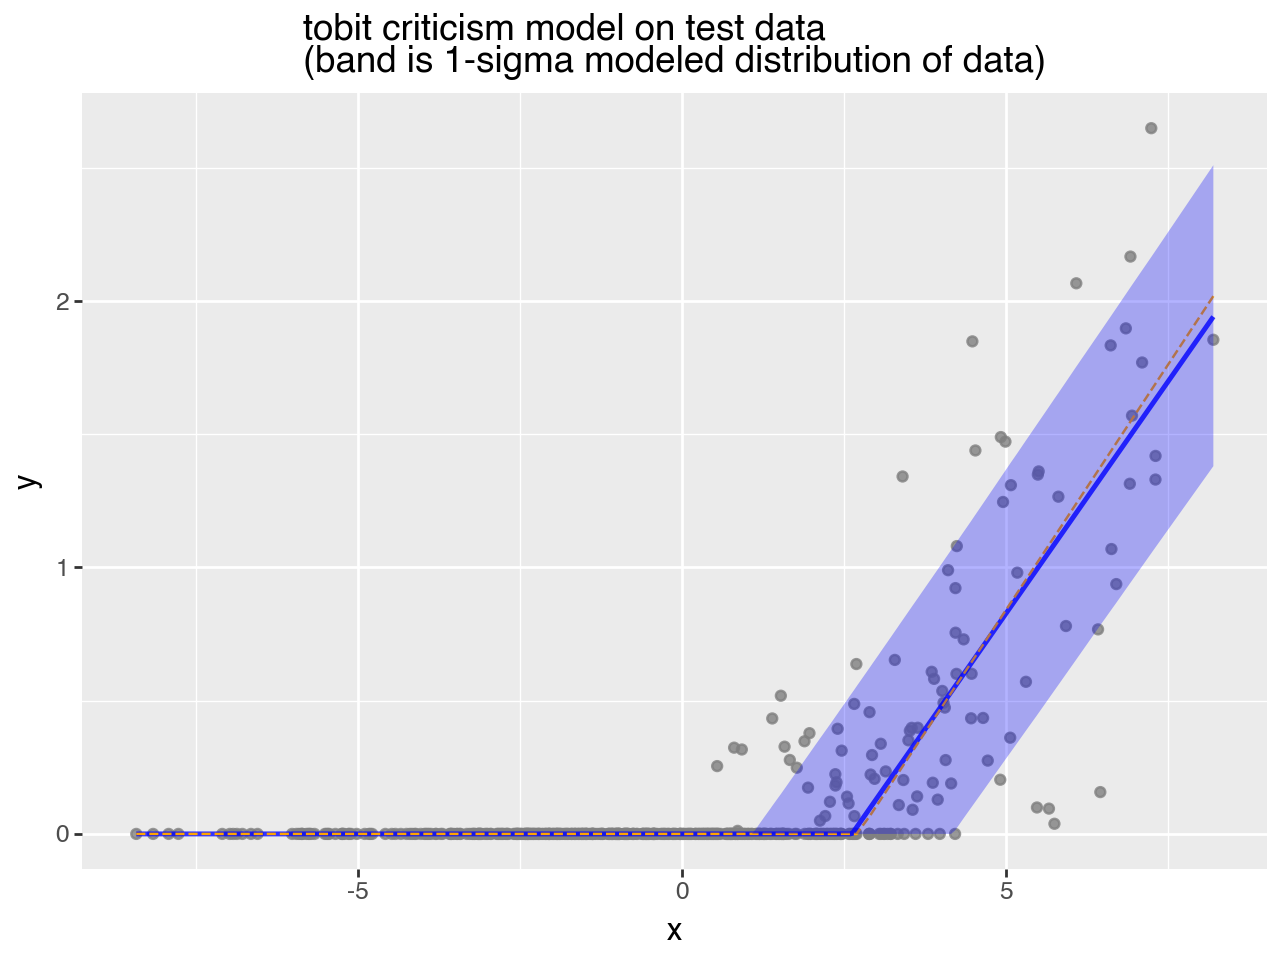

In [19]:
add_in_predictions_and_plot(
    res_picked, 
    model_name="tobit criticism model")

We nearly perfectly recovered the actual data generating relationship!

That is the key to Stan: as long as you have an identifiable system and you guess the structure of the system, you have a good chance of estimating the parameters.

In the above we were a bit brutal- not supplying Stan with addition problem hints such as priors. Priors can help, but it is okay to get them wrong (or omit them). When you have data, priors tend not be be as critical as specifying the correct causal relations or model structure.

It is considered a bit more civilized to have some distributional effects on all variables, directly or indirectly.  We were earlier computing a loss that we could consider to be the logarithm of `P[observations | parameters]`. If we add in `P[parameters]` to instead evaluate `P[parameters] P[observations | parameters]` we are now (by Bayes' Law) computing something directly proportional to `P[parameters | data]`. I.e. we would be performing a proper Bayesian inference. 

Let's add those extra effects and try the new system. Also note, we have translated the `target += normal_lpdf(y_pos | x_pos * a + b, sigma);` term into an equivalent distributional statement: `y_pos ~ normal(x_pos * a + b, sigma);`. The `target += normal_lcdf()` isn't so translatable, as there is no random variable whose distribution is the normal CDF.

That being said, let's run the new formulation.

In [20]:

# specify our Stan model in a more distributional manner
stan_model_probability_src = """
data {
  int<lower=1> n_vars;               // number of explanatory variables
  int<lower=0> m_positive;           // number of positive observations
  int<lower=0> m_zero;               // number of zero observations
  matrix[m_positive, n_vars] x_pos;  // explanatory variable for positive outcomes
  vector[m_positive] y_pos;          // observed positive outcomes
  matrix[m_zero, n_vars] x_zero;     // explanatory variable for non-positive outcomes
}
parameters {
  vector[n_vars] a;                  // regression slope(s)
  real b;                            // regression intercept
  real<lower=0> sigma;               // variance / noise level
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(10);
      // tobit style model structure
  y_pos ~ normal(x_pos * a + b, sigma);
  target += normal_lcdf(0 | x_zero * a + b, sigma);
}
"""


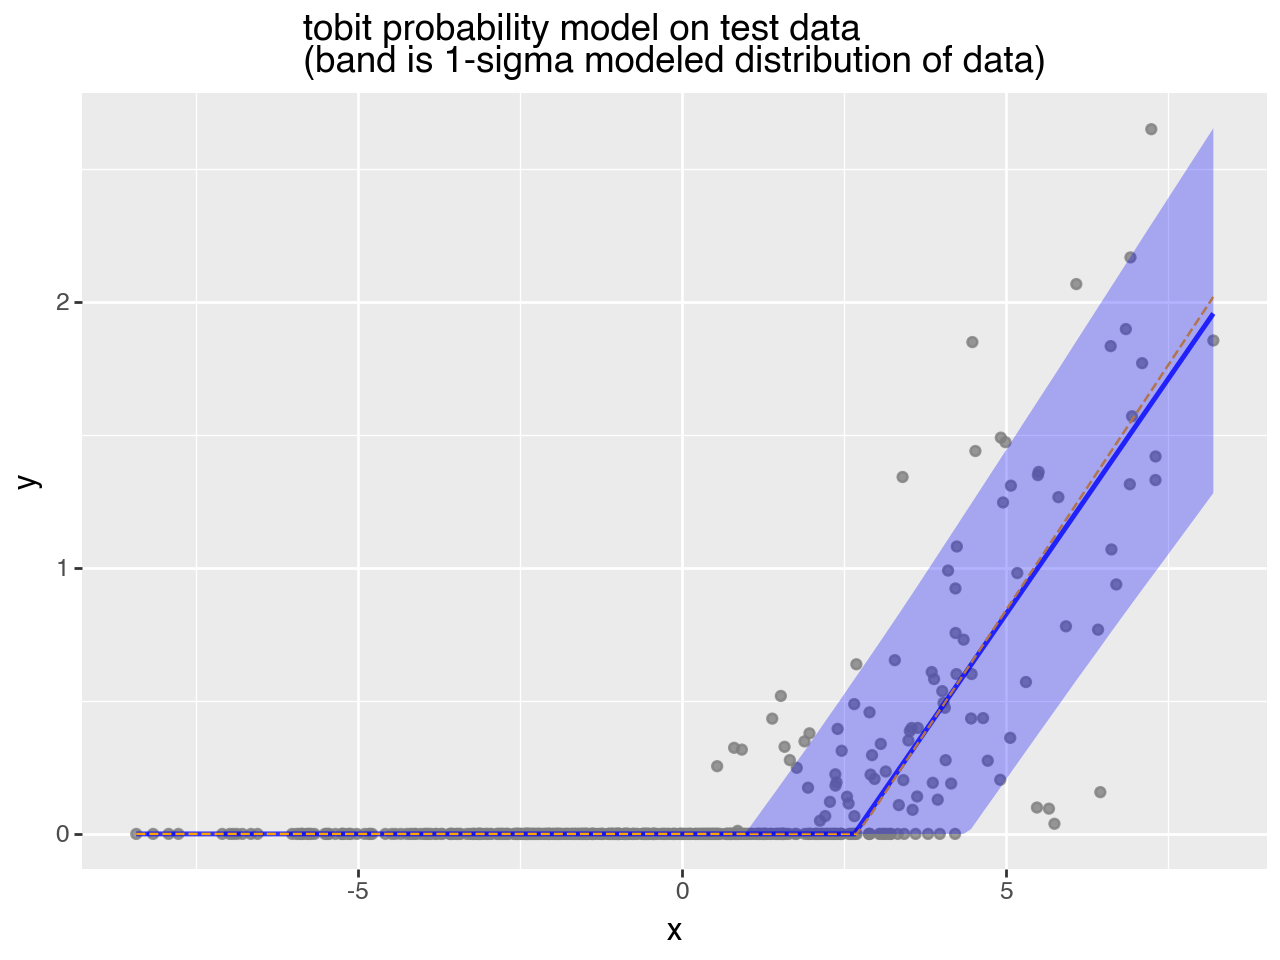

In [21]:
# run again
res_prob = run_stan_model(
    stan_model_probability_src, 
    stan_file_name='probability_model.stan')

add_in_predictions_and_plot(
    res_prob, 
    model_name="tobit probability model")

Notice we get a similar answer. This is to be expected. Sufficiently flat priors become irrelevant as we add enough data. One can look to tools such as the [Bernstein–von Mises theorem](https://en.wikipedia.org/wiki/Bernstein–von_Mises_theorem) to support such claims.